# ANN Surrogate Model - Rhodamine Control Case
In this notebook, we will train a artificial neural network to map from the vascular hydraulic conductivity (Lpt) and interstitial hydraulic conductivity (Kt) to the spatially averaged accumulation profile over a time horizon of 5 minutes.

First we import the pre-requisite packages:
- Surrogates.jl is used for sampling and creating training data
- Flux.jl is used for training and developing the ANN Model
- Statistics.jl provides useful functions for assessing the ANN model performance
- DifferentialEquations.jl is used for simulating the mechanistic model
- Plots.jl is used for plotting purposes
- Suppressor.jl is used for suppressing warnings associated with numerical issues that already have error handling in the code

In [1]:
using Surrogates,Flux,Statistics,DifferentialEquations,Plots,Suppressor
include("soluteperm.jl")

soluteperm (generic function with 1 method)

Next, we set the bounds on our sample space:

In [2]:
#set lower and upper bounds on Lpt and Kt (Lpt is first element and Kt is second element)
#control
lb=Float32[1e-7,1e-7]
ub=Float32[1.75e-6,1e-6]

#dosage
#lb=[5e-7,7e-7]
#ub=[3.5e-6,4e-6]

2-element Vector{Float32}:
 1.75f-6
 1.0f-6

We will now provide the scaler functions for the input and output data. The inputs (Lpt & Kt) are scaled using Min-Max scaling. For simplicity, the outputs are scaled using a factor of .3 as this was found to be a reasonable upperbound on the maximum accumulation.

In [3]:
#Define scaler functions to preprocess data
scaler(x)= ((x[1]- lb[1])/(ub[1]-lb[1]),(x[2]- lb[2])/(ub[2]-lb[2]))
invscaler(x_sc)=(x_sc[1]*(ub[1]-lb[1]) + lb[1],x_sc[2]*(ub[2]-lb[2]) + lb[2])
output_scaler(x)= x ./ .3
inv_output_scaler(x)=x.*.3

inv_output_scaler (generic function with 1 method)

Next, we define the functions used for the mechanistic modeling process. For this, we integrate the convection-diffusion partial differential equations using the methods of lines and the QNDF solver provided by DifferentialEquations.jl. We have built into this model handling for numerical issues associated with the peclet expression in the source term exploding. This is done by switching between the Low Peclet model and the High Peclet model depending on the feasibility of the Low Peclet model.

In [4]:
function a_pressure(r,α)
    return r == 0 ? 1 - csch(α) : 1 - sinh(α*r)/(r*sinh(α))
    #return 1 - sinh(α*r)/(r*sinh(α))
end
function a_pressure_prime(r,α)
    return r == 0 ? 0 : (sinh(α*r)-α*r*cosh(r*α))/(sinh(α)*r^2)
    #return (sinh(α*r)-α*r*cosh(r*α))/(sinh(α)*r^2)
end
function MSTHighPeclet!(dc,c,p,t)
    #dc = preallocated vector corresponding to f(c,t)= dC/dt
    #c = concentration vector at all spatial points
    #p = vector of parameters as define in modelanalysis
    #t = current time
    #Unpackage parameters
    P,N,sigma,Perm,Lpt,Svt,Kt,Pvv,Pv,D,r,dr,kd=p
    co=1 #initial concentration
    tspan=3600 #timespan
    cv=co*exp(-t*tspan/kd) #time-dependent exponential decay term
    Pe=Lpt*Pv*(Pvv-P[1])*(1-sigma)/Perm #Initial Peclet value
    #interior boundary condition
    dc[1]=tspan*(2*D*(c[2]-c[1])/dr^2 +Lpt*Svt*Pv*(Pvv-P[1])*(1-sigma)*cv)
    for j=2:N-1
        dc[j]=tspan*(((2*D/r[j])*((c[j+1]-c[j])/dr))+(D*(c[j+1]-2*c[j]+c[j-1])/dr^2)+ Kt*((P[j+1]-P[j-1])/(2*dr))*((c[j+1]-c[j])/dr)+ Lpt*Svt*Pv*(Pvv-P[j])*(1-sigma)*cv)
    end
    dc[N]=0 # concentration at the outtermost boundary
end
function MST!(dc,c,p,t)
    #dc = preallocated vector corresponding to f(c,t)= dC/dt
    #c = concentration vector at all spatial points
    #p = vector of parameters as define in modelanalysis
    #t = current time
    #Unpackage parameters
    P,N,sigma,Perm,Lpt,Svt,Kt,Pvv,Pv,D,r,dr,kd=p
    co=1 #initial concentration
    tspan=3600 #timespan
    cv=co*exp(-t*tspan/kd) #time-dependent exponential decay term
    Pe=Lpt*Pv*(Pvv-P[1])*(1-sigma)/Perm #Initial Peclet value
    dc[1]= tspan*(2*D*(c[2]-c[1])*dr^-2 + Lpt*Svt*Pv*(Pvv-P[1])*(1-sigma)*(cv*exp(Pe)-c[1])/(exp(Pe)-1)) # R=0 boundary condition
    for j=2:N-1
        #Define interior nodes
        Pe=Lpt*Pv*(Pvv-P[j])*(1-sigma)/Perm #Peclet number
        dc[j]=tspan*(((2*D/r[j])*((c[j+1]-c[j])/dr))+(D*(c[j+1]-2*c[j]+c[j-1])/dr^2)+ Kt*((P[j+1]-P[j-1])/(2*dr))*((c[j+1]-c[j])/dr)+ Lpt*Svt*Pv*(Pvv-P[j])*(1-sigma)*(cv*exp(Pe)-c[j])/(exp(Pe)-1))
    end
    dc[N]=0 # concentration at the outtermost boundary
end
function Accumulation_Model(sol,n_spatial,n_time,n_nodes)
    c_model=zeros(n_nodes)
    spacingfactor = n_time ÷ n_nodes
    for j=1:n_nodes
        c_model[j]=mean(sol[:,spacingfactor*j])
    end
    return c_model
end
function accumlation_intermediate(x) #x is a vector containing Lpt and Kt
    n_spatial=100
    n_time=21
    n_nodes = 21 # number of nodes desired to be outputted for accumulation data
    Lpt,Kt = x
    Svt = 200;      #tumor vascular density
    D = 2e-07;  #solute diffusion coefficient
    rs = 13/2;      #partical radius (nm)
    Perm,sigma=soluteperm(Lpt,rs) #Vascular permeability and solute reflection coefficient respectively
    R=1. # Tumor Radius
    Pv=25. #
    Pvv=1.
    kd=1480*60 # blood circulation time of drug in hours;
    att=R*sqrt(Lpt*Svt/Kt) #parameter alpha for tumor, ignoring lymphatics
    Press(r)= a_pressure(r,att)
    co=1.
    tdomain=300

    r= (1/R)*(range(0,stop=R,length=n_spatial))
    dr=1/(n_spatial-1)

    P= broadcast(Press,r)

    c0=zeros(n_spatial,1)
    c0[end]=0.
    #define timespan
    time_end =(300/3600)
    tspan=(0.,time_end)
    #package parameters
    p=P,n_spatial,sigma,Perm,Lpt,Svt,Kt,Pvv,Pv,D,r,dr,kd
    #Define and solve system of ODEs using time constant of 1/n_nodes and the QNDF solver for stiff systems
    dt=time_end/(n_time-1)
    #t = dt*[i for i=0:n_nodes-1]
    prob=ODEProblem(MST!,c0,tspan,p)
    sol= solve(prob,QNDF(),saveat=dt)
    if length(sol.t)==1
        prob=ODEProblem(MSTHighPeclet!,c0,tspan,p)
        sol= solve(prob,QNDF(),saveat=dt)
    end
    accum_dat = Accumulation_Model(sol,n_spatial,n_time,n_nodes)
    return output_scaler(accum_dat)
end
accum(x) = accumlation_intermediate(invscaler(x))

accum (generic function with 1 method)

We will now specify the size of our data set prior to generation. We perform a 70/30 split for training and test data respectively. We typically generate a million data points as this was found to be a balance between data generation time and training accuracy. 

To sample we utilize the Sobol Sampling procedure provided by Surrogates.jl. We then reshape the dataset into matrix form for ease of readabilitiy.

The data is then processed into two different forms:
- The first form is a batch data set
- The second form is a mini-batch data set which is a tenth of the size of the original training data

In [5]:
#Specify number of samples to generate and perform 70:30 split for data generation
n_samp=1e6;
n_train =Int64(n_samp*.7);
n_test = Int64(n_samp*.3);

In [6]:
#Create training and test data sets
x_train=reshape([x[j] for x in scaler.(sample(n_train, lb,ub, SobolSample())) for j in eachindex(x)],(2,n_train));
y_train =reshape([y[j] for y in [accum(col) for col in eachcol(x_train)] for j in eachindex(y)],(21,n_train));
println("70 Percent Done")
x_test=reshape([x[j] for x in scaler.(sample(n_test, lb,ub, SobolSample())) for j in eachindex(x)],(2,n_test));
y_test=reshape([y[j] for y in [accum(col) for col in eachcol(x_test)] for j in eachindex(y)],(21,n_test));

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

In [7]:
#package data
using Flux.Data: DataLoader
bsize = n_train ÷ 10
data_mb = DataLoader((x_train,y_train),batchsize=bsize)
data = DataLoader((x_train,y_train))

DataLoader{Tuple{Matrix{Float32}, Matrix{Float64}}}((Float32[2.859396f-6 0.50000286 … 0.5571265 0.057126526; 0.31250477 0.81250477 … 0.2163272 0.7163272], [0.0 0.0 … 0.0 0.0; 0.0037483848452770792 0.015969448197350817 … 0.009673740755620674 0.007531206191787856; … ; 0.07025086188995505 0.29622416433643306 … 0.17638369694861278 0.14118125410199878; 0.07390466133366329 0.3114755301206406 … 0.18532253172230811 0.14852083988670628]), 1, 700000, true, 700000, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  699991, 699992, 699993, 699994, 699995, 699996, 699997, 699998, 699999, 700000], false)

Next we build the ANN model architecture:

For this model, we use 2 hidden layers with 24 nodes and the swish activation function as this combination was found to provide accurate results with a lower computational load for training. The loss function is the mean squared errors with the ADAM optimizer using a learning rate of 10^-3. 

In [8]:
#Specify Neural Network Structure
n=24
activation_func=Flux.swish
NN = Chain(Dense(2,n),Dense(n,n,activation_func),Dense(n,n,activation_func),Dense(n,21))
loss(x,y) = Flux.mse(NN(x),y)
learning_rate = 1e-3
optimizer = ADAM(learning_rate)
n_epochs = 50;
ps = Flux.params(NN);
ϵ=1e-7;

The following training procedure is used:
We train the model for two iterations of batch gradient descent and then we train the model for 50 epochs using mini-batch gradient descent. The early stopping criteria used is a tolerance of ϵ=1e-7. 

In [17]:
Flux.train!(loss, ps, data, optimizer)
Flux.train!(loss, ps, data, optimizer)
@show loss(x_train,y_train)
#epoch_l = zeros(n_epochs);
for i=1:n_epochs
    Flux.train!(loss, ps, data_mb, optimizer)
    l=loss(x_train,y_train)
    #epoch_l[i]=l
    @show(i,l)
    if l < ϵ 
        break
    end
end

loss(x_train, y_train) = 9.65944893212279e-7
i = 1
l = 8.305160768216301e-7
i = 2
l = 7.317142662128838e-7
i = 3
l = 6.667080039450824e-7
i = 4
l = 6.188883105149775e-7
i = 5
l = 5.893430898260502e-7
i = 6
l = 5.713144423285961e-7
i = 7
l = 5.60221798526678e-7
i = 8
l = 5.531746983278491e-7
i = 9
l = 5.480931441311054e-7
i = 10
l = 5.4409413286719e-7
i = 11
l = 5.4075406584667e-7
i = 12
l = 5.37861810579142e-7
i = 13
l = 5.353020491747538e-7
i = 14
l = 5.330046143017474e-7
i = 15
l = 5.309244350171333e-7
i = 16
l = 5.290305846456832e-7
i = 17
l = 5.273016325181719e-7
i = 18
l = 5.25719981752909e-7
i = 19
l = 5.242716463748271e-7
i = 20
l = 5.229440487761834e-7
i = 21
l = 5.217260001726263e-7
i = 22
l = 5.206076441594781e-7
i = 23
l = 5.195805670574767e-7
i = 24
l = 5.186355429728708e-7
i = 25
l = 5.177653305352692e-7
i = 26
l = 5.16963189592585e-7
i = 27
l = 5.16223016238037e-7
i = 28
l = 5.155386770131374e-7
i = 29
l = 5.149051063796378e-7
i = 30
l = 5.143175825279226e-7
i = 31
l = 5.

We then provide several procedures to assess the accuracy of the ANN model on several metrics:
- The first metric is the mean squared error on the test set
- The second metric used is the mean and std of the percent error defined as abs((c_mech-c_ANN)/c_mech)*100 over the test set
- The third metric used is a plot used to visualize the percent error across the entire sample space of Lpt and Kt

In [10]:
loss(x_test,y_test)

5.965809871465689e-7

In [18]:
#Estimate Percent Error between ANN model and mechanistic model
#Must ignore first element because of divide by 0 error
y_test_inv_scaled= inv_output_scaler(y_test)
y_test_mod = inv_output_scaler(NN(x_test))
percent_diff(orig,new) = orig == 0 ? NaN : abs((orig-new)/orig)*100
error_mat =percent_diff.(y_test_inv_scaled,y_test_mod)
error_mat = error_mat[2:end,:]
mean_errors=[mean(error_mat[:,i]) for i =1:n_test]
mean_error = mean(mean_errors);
std_error = std([mean(error_mat[:,i]) for i =1:n_test]);
@show mean_error;
@show std_error;



mean_error = 0.31424585324492876
std_error = 0.8888875416888751


In [12]:
mean_error_func(x) =mean(percent_diff.(inv_output_scaler(accum(collect(scaler(x)))),inv_output_scaler(NN(collect(scaler(x)))))[2:end])

mean_error_func (generic function with 1 method)

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffE

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

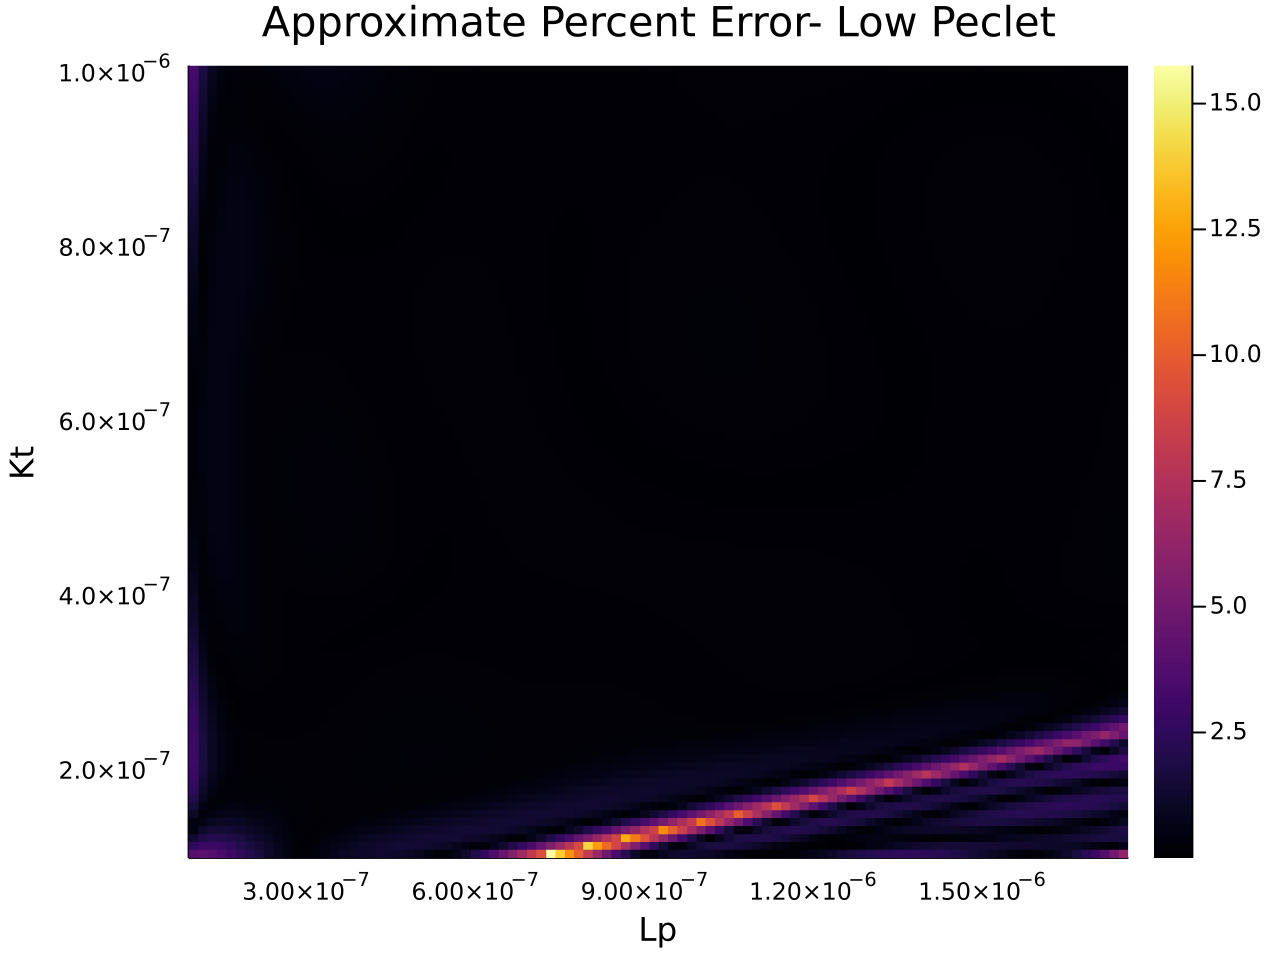

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\initdt.jl:76
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: First function call produced NaNs. Exiting.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\pac

┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq C:\Users\stm16109\.julia\packages\OrdinaryDiffEq\VPJBD\src\solve.jl:459
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\stm16109\.julia\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323


In [19]:
@suppress_err begin
n_points = 100
#lp_d = lb[1]:(ub[1]-ub[1])/n_points:ub[1]
#kt_d = lb[2]:(ub[2]-ub[2])/n_points:ub[2]
lp_d=range(lb[1], ub[1], length=n_points)
kt_d= range(lb[2], ub[2], length=n_points)
err = reshape([mean_error_func([l,k]) for l in lp_d for k in kt_d],(n_points,n_points))
scale_factor =1
errplot = plot(lp_d,kt_d, err,title = "Approximate Percent Error- Low Peclet",
xlabel="Lp",
ylabel="Kt",
linetype=:heatmap,
size = (640*scale_factor,480*scale_factor),
dpi=200
);
display(errplot)
end

Finally the model is saved using the BSON loader provided by Flux

In [20]:
using BSON: @save
@save "P:\\FinalModels\\rhodaminecontrol.bson" NN

This concludes our tutorial of using the ANN surrogate development process provided in this notebook. 